In [1]:
from shared.preface import *
import shared.functions as fct

### 2D grid, center coord. pairs.

In [2]:
def grid_2D(l, s):

    # 2D spatial grid, discretized.
    eps = s/10
    x, y = np.mgrid[-l:l+eps:s, -l:l+eps:s]

    # [x y] edge coordinate pairs of above grid.
    xy = np.mgrid[-l:l+eps:s, -l:l+eps:s].reshape(2,-1).T

    # Create center coord.-pairs.
    x_centers = (x[1:,:] + x[:-1,:])/2.
    y_centers = (y[:,1:] + y[:,:-1])/2.
    centers = np.array([x_centers[:,:-1], y_centers[:-1,:]])
    cent_coordPairs2D = centers.reshape(2,-1).T
    print('All coord. pairs 2D:\n', cent_coordPairs2D)
    # print('Coord pairs 2D shape:', cent_coordPairs2D.shape)

    return cent_coordPairs2D

limit_coarse, space_coarse = 1.5, 1.
cent_coordPairs2D = grid_2D(limit_coarse, space_coarse)

# Delete middle square.
cent_coordPairs2D = np.delete(cent_coordPairs2D, 4, axis=0)

# Create finegrained square.
limit_fine, space_fine = limit_coarse/2., space_coarse/2.
cent_coordPairs2D_fine = grid_2D(limit_fine, space_fine)

# Insert finegrained square.

All coord. pairs 2D:
 [[-1. -1.]
 [-1.  0.]
 [-1.  1.]
 [ 0. -1.]
 [ 0.  0.]
 [ 0.  1.]
 [ 1. -1.]
 [ 1.  0.]
 [ 1.  1.]]
All coord. pairs 2D:
 [[-0.5 -0.5]
 [-0.5  0. ]
 [-0.5  0.5]
 [ 0.  -0.5]
 [ 0.   0. ]
 [ 0.   0.5]
 [ 0.5 -0.5]
 [ 0.5  0. ]
 [ 0.5  0.5]]


### 3D grid, center coord. pairs.

In [3]:
# 3D spatial grid, discretized.
x, y, z = np.mgrid[-1:1.1:1., -1:1.1:1., -1:1.1:1.]
# print(x[0,...], x.shape)

x_centers = (x[1:,...] + x[:-1,...])/2.
# print(x_centers, x_centers.shape)

y_centers = (y[:,1:,:] + y[:,:-1,:])/2.
# print(y_centers, y_centers.shape)

z_centers = (z[...,1:] + z[...,:-1])/2.
# print(z_centers, z_centers.shape)


# Create center coord.-pairs., truncate redundant points.
centers3D = np.array([
    x_centers[:,:-1,:-1], 
    y_centers[:-1,:,:-1], 
    z_centers[:-1,:-1,:]
])
# print(centers3D, centers3D.shape)

cent_coordPairs3D = centers3D.reshape(3,-1).T 
print(cent_coordPairs3D, cent_coordPairs3D.shape)

[[-0.5 -0.5 -0.5]
 [-0.5 -0.5  0.5]
 [-0.5  0.5 -0.5]
 [-0.5  0.5  0.5]
 [ 0.5 -0.5 -0.5]
 [ 0.5 -0.5  0.5]
 [ 0.5  0.5 -0.5]
 [ 0.5  0.5  0.5]] (8, 3)


### Build "cubic" grid for Milky Way Virial halo and beyond.

In [4]:
def read_DM_positions_randomHalo(which_halos, mass_select):

    # Open data files.
    folder = SIM_DATA
    snaps = h5py.File(f'{folder}/snapshot_0036.hdf5')
    group = h5py.File(f'{folder}/subhalo_0036.catalog_groups')
    parts = h5py.File(f'{folder}/subhalo_0036.catalog_particles')
    props = h5py.File(f'{folder}/subhalo_0036.properties')

    ### Properties of DM particles.

    # Positions.
    a = snaps["/Header"].attrs["Scale-factor"]
    pos = snaps['PartType1/Coordinates'][:][:] * a  
    #! comoving to physical (pc) with a, then *1e3 to go to kpc

    # Masses.
    mass = snaps['PartType1/Masses'][:] * 1e10  
    print(f'{mass[0]:.2e}')
    print(mass[0])
    #! some choice of Camila, *1e10 to get to Msun. All DM particles have same mass.

    # Velocities.
    vel = snaps['PartType1/Velocities'][:][:]  #! in km/s, physical

    # NFW concentration parameter.
    cNFW = props['cNFW_200crit'][:]

    # Virial radius.
    rvir = props['R_200crit'][:] *1e3 # now in kpc
    
    # Critical M_200.
    m200c = props['Mass_200crit'][:] * 1e10  # now in Msun

    # Set neg. values to 1, i.e. 0 in np.log10.
    m200c[m200c <= 0] = 1

    # This gives exponents of 10^x, which reproduces m200c vals.
    m200c = np.log10(m200c)  

    # Center of Potential coordinates, for all halos.
    CoP = np.zeros((len(m200c), 3))
    CoP[:, 0] = props["Xcminpot"][:]
    CoP[:, 1] = props["Ycminpot"][:]
    CoP[:, 2] = props["Zcminpot"][:]

    # Select halos based on exponent, i.e. mass_select input parameter.
    select_halos = np.where(
        (m200c >= mass_select-0.2) & (m200c <= mass_select+0.2)
    )[0]


    # Selecting subhalos or halos.
    subtype = props["Structuretype"][:]
    if which_halos == 'subhalos':
        select = np.where(subtype[select_halos] > 10)[0]
        select_halos = select_halos[select]
    else:
        select = np.where(subtype[select_halos] == 10)[0]
        select_halos = select_halos[select]

    # Select 1 random halo.
    np.random.seed(SEED)
    select_random = np.random.randint(len(select_halos) - 1, size=(1))
    rand_halo = select_halos[select_random]

    # Grab the start position in the particles file to read from
    halo_start_pos = group["Offset"][rand_halo][0]
    halo_end_pos = group["Offset"][rand_halo + 1][0]

    particle_ids_in_halo = parts["Particle_IDs"][halo_start_pos:halo_end_pos]
    particle_ids_from_snapshot = snaps["PartType1/ParticleIDs"][...]

    # Get indices of elements, which are present in both arrays.
    _, _, indices_p = np.intersect1d(
        particle_ids_in_halo, particle_ids_from_snapshot, 
        assume_unique=True, return_indices=True
    )

    particles_mass = mass[indices_p]
    particles_pos = pos[indices_p, :]  # : grabs all 3 spatial positions.
    particles_pos -= CoP[rand_halo, :]  # centering, w.r.t halo they're part of
    particles_pos *= 1e3  # to kpc


    # Save positions relative to CoP (center of halo potential).
    np.save(
        f'sim_data/DM_positions_{which_halos}_M{mass_select}.npy',
        particles_pos,
    )


read_DM_positions_randomHalo(which_halos='halos', mass_select=12)

1.15e+07
11502999.0


In [5]:
from sys import getsizeof

def grid_3D(l, s):

    # Generate edges of 3D grid.
    x, y, z = np.mgrid[-l:l+0.1:s, -l:l+0.1:s, -l:l+0.1:s]
    
    # Calculate centers of each axis.
    x_centers = (x[1:,...] + x[:-1,...])/2.
    y_centers = (y[:,1:,:] + y[:,:-1,:])/2.
    z_centers = (z[...,1:] + z[...,:-1])/2.

    # Create center coord.-pairs., truncate redundant points.
    centers3D = np.array([
        x_centers[:,:-1,:-1], 
        y_centers[:-1,:,:-1], 
        z_centers[:-1,:-1,:]
    ])

    cent_coordPairs3D = centers3D.reshape(3,-1).T 

    return cent_coordPairs3D


#! for limit = Rvir_MW, the kernel crashes
limit, spacing = Rvir_MW, 100*kpc
grid_V1 = grid_3D(limit, spacing) / kpc
print(grid_V1.shape)

# Memory/size of array.
# print(round(getsizeof(grid_V1) /1024**2, 2))
print(getsizeof(grid_V1) /1024**2, 'MB')

(216, 3)
0.00505828857421875 MB


### 3D plot of the DM particles.

(126187, 3)


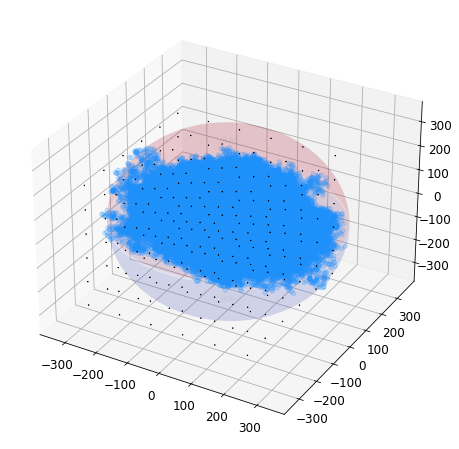

In [12]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

# Read in DM particle positions.
DM_pos = np.load('sim_data/DM_positions_halos_M12.npy')
print(DM_pos.shape)
x_DM, y_DM, z_DM = DM_pos[:,0], DM_pos[:,1], DM_pos[:,2]
cut = 1
x, y, z = x_DM[1::cut], y_DM[1::cut], z_DM[1::cut]

ax.scatter(x, y, z, alpha=0.2, c='dodgerblue')

# Draw sphere around GC with radius=Rvir_MW.
rGC = Rvir_MW/kpc
uGC, vGC = np.mgrid[0:2 * np.pi:200j, 0:np.pi:100j]
xGC = rGC * np.cos(uGC) * np.sin(vGC)
yGC = rGC * np.sin(uGC) * np.sin(vGC)
zGC = rGC * np.cos(vGC)

xg, yg, zg = grid_V1[:,0], grid_V1[:,1], grid_V1[:,2] 
ax.scatter(xg, yg, zg, s=0.2, marker='x', color='black', alpha=1)


ax.plot_surface(
    xGC, yGC, zGC, alpha=0.1, 
    cmap=plt.cm.coolwarm, vmin=-1, vmax=1,# antialiased=False,
    rstride=1, cstride=1
)

plt.show()

### Calculate gravity in each cell.

In [7]:
def cell_gravity(cell_coords, grav_range, m_DM):
    
    # Center all DM positions w.r.t. cell center (cc).
    DM_pos_cc = DM_pos*kpc - cell_coords

    # Calculate distances of DM to cc, sorted in ascending order.
    DM_dist_cc = np.sqrt(np.sum(DM_pos_cc**2, axis=1))

    # Ascending order indices.
    ind = DM_dist_cc.argsort()

    # Truncate DM positions depending on distance to cc.
    DM_pos_cc_sort = DM_pos_cc[ind]
    DM_pos_trunc = DM_pos_cc_sort[DM_dist_cc[ind] <= grav_range]
    print(f'{len(DM_pos_trunc)} DM particles inside range')

    ### Calculate superposition gravity.
    pre = G*m_DM
    denom = np.power(np.sum((cell_coords-DM_pos_trunc)**2), 3./2.)

    return pre*np.sum((cell_coords-DM_pos_trunc)/denom, axis=0)



### Testing 1 cell.

# Coords. of 1 cell.
cell_id = 0
# cell1 = np.array([xg[cell_id], yg[cell_id], zg[cell_id]])*kpc
cell1 = np.array([8.5, 0, 0])*kpc

grav_range = 100*spacing/np.sqrt(2)
mass_DM = 11502999*Msun

cell_vector = cell_gravity(cell1, grav_range, mass_DM)
cell_vector/= (kpc/s**2)
print(cell_vector)
print(np.sum(cell_vector**2))


126187 DM particles inside range
[ 7.85970873e-40 -1.37574642e-40  1.06935706e-41]
6.367913481530823e-79


### Find in which cell the neutrino with position $\vec{x}$ is.

In [8]:
def nu_in_which_cell(nu_coords, cell_coords):

    # For now, just subtract nu_coords from all cell_coords, then take min.
    dist = np.sqrt(np.sum((np.abs(cell_coords-nu_coords)**2), axis=1))
    cell_idx = dist.argmin()

    return cell_idx

### Derivatives and positions of grid of snapshots will be stored. 

In [9]:
def load_derivative_grid(z):

    '''
    # ID corresponding to current z.
    idx = np.abs(Z_SNAPSHOTS - z).argmin()

    # Load file with derivative grid of ID.
    dPsi_grid = np.load(f'~/sim_data/derivative_grid_{idx}')

    return dPsi_grid
    '''

def load_grid_positions(z):

    '''
    # ID corresponding to current z.
    idx = np.abs(Z_SNAPSHOTS - z).argmin()

    # Load file with position grid of ID.
    X_grid = np.load(f'~/sim_data/position_grid_{idx}')

    return X_grid
    '''

### Voxels.

[[[0 0]
  [0 0]]

 [[1 1]
  [1 1]]]


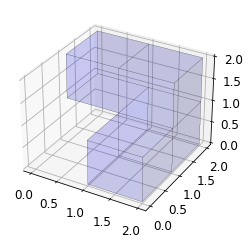

In [10]:
# prepare some coordinates
x, y, z = np.indices((2, 2, 2))
print(x)
# combine the objects into a single boolean array
# voxelarray = cube1 | cube2 | link
s = np.max(x)/2
voxelarray = x|y|z
voxelarray = np.array([ [[0,0],[0,1]], [[1,0],[1,1]] ])
# print(voxelarray)

# set the colors of each object
# colors = np.empty(voxelarray.shape, dtype=object)
# colors[link] = 'red'
# colors[cube1] = 'blue'
# colors[cube2] = 'green'

# and plot everything
ax = plt.figure().add_subplot(projection='3d')
ax.voxels(voxelarray, 
    facecolors='blue', edgecolor='k', alpha=0.1, 
    linewidth=0.1,
)

plt.show()

[8 6 8]
(7, 5, 7)


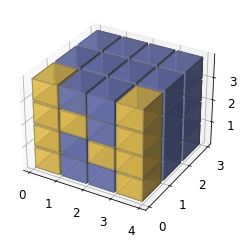

In [11]:
import matplotlib.pyplot as plt
import numpy as np


def explode(data):
    size = np.array(data.shape)*2
    data_e = np.zeros(size - 1, dtype=data.dtype)
    data_e[::2, ::2, ::2] = data
    return data_e

# build up the numpy logo
n_voxels = np.zeros((4, 3, 4), dtype=bool)
n_voxels[0, 0, :] = True
n_voxels[-1, 0, :] = True
n_voxels[1, 0, 2] = True
n_voxels[2, 0, 1] = True
facecolors = np.where(n_voxels, '#FFD65DC0', '#7A88CCC0')
edgecolors = np.where(n_voxels, '#BFAB6E', '#7D84A6')
filled = np.ones(n_voxels.shape)

# upscale the above voxel image, leaving gaps
filled_2 = explode(filled)
fcolors_2 = explode(facecolors)
ecolors_2 = explode(edgecolors)

ok = np.array(filled_2.shape) + 1
print(ok)
print(filled_2.shape)

# Shrink the gaps
x, y, z = np.indices(np.array(filled_2.shape) + 1).astype(float) // 2
x[0::2, :, :] += 0.05
y[:, 0::2, :] += 0.05
z[:, :, 0::2] += 0.05
x[1::2, :, :] += 0.95
y[:, 1::2, :] += 0.95
z[:, :, 1::2] += 0.95

ax = plt.figure().add_subplot(projection='3d')
ax.voxels(x, y, z, filled_2, facecolors=fcolors_2, edgecolors=ecolors_2)

plt.show()